# Pre-requisites

In [293]:
# sets *your* project id
PROJECT_ID = "esicmdatathon2024" #@param {type:"string"}


In [294]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'version1_5_0' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

In [295]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')


Authenticated


In [296]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [297]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config


# Libraries

In [298]:
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns
sns.set_style('darkgrid')

# Checking data
ignore this in subsequent runs

## Check weight


In [299]:
%%bigquery check_weight --project esicmdatathon2024
SELECT m.visit_occurrence_id, m.value_as_number, measurement_datetime
  FROM measurement m
  WHERE measurement_concept_id in (3026600, 3013762, 3023166, 3025315) -- Body Weight
    AND m.provider_id IS NULL


Query is running:   0%|          |

Downloading:   0%|          |

In [300]:
s = check_weight.select_dtypes(include='object').columns
check_weight[s] = check_weight[s].astype("float")

In [301]:
check_weight.describe()

,visit_occurrence_id,value_as_number
count,22160.0,22160.000000
mean,11768.191471,80.082130
std,6786.961027,14.701707
min,0.0,55.000000
25%,5877.75,75.000000
50%,11769.5,75.000000
75%,17639.25,85.000000
max,23552.0,115.000000


<Axes: xlabel='value_as_number', ylabel='Count'>

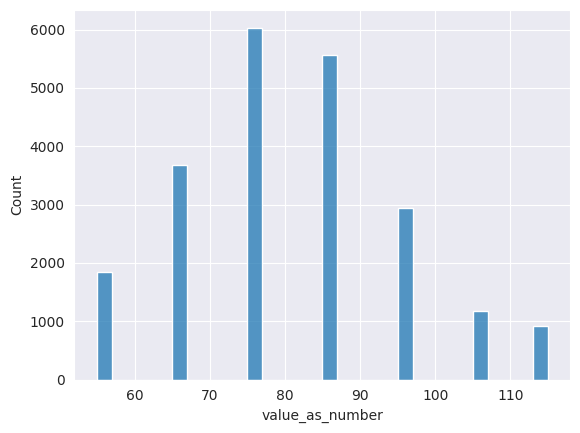

In [302]:
sns.set_style('darkgrid')
sns.histplot(check_weight['value_as_number'], bins=30)


## Check urine output

In [303]:
%%bigquery check_urine --project esicmdatathon2024
SELECT m.visit_occurrence_id, m.value_as_number, measurement_datetime , measurement_source_value
  FROM measurement m
  WHERE measurement_concept_id in (3014315, 3016267, 21491173, 3007123) -- Urine
    AND m.provider_id IS NOT NULL
    and visit_occurrence_id = 19134
    order by measurement_datetime
limit 100

Query is running:   0%|          |

Downloading:   0%|          |

In [304]:
check_urine

,visit_occurrence_id,value_as_number,measurement_datetime,measurement_source_value
0,19134,200.00000000000000000000000000000000000000,2006-01-01 03:17:00+00:00,UrineCAD
1,19134,200.00000000000000000000000000000000000000,2006-01-01 03:17:00+00:00,UrineCAD
2,19134,450.00000000000000000000000000000000000000,2006-01-01 04:17:00+00:00,UrineCAD
3,19134,450.00000000000000000000000000000000000000,2006-01-01 04:17:00+00:00,UrineCAD
4,19134,80.00000000000000000000000000000000000000,2006-01-01 05:17:00+00:00,UrineCAD
...,...,...,...,...
95,19134,90.00000000000000000000000000000000000000,2006-01-03 05:17:00+00:00,UrineCAD
96,19134,60.00000000000000000000000000000000000000,2006-01-03 06:17:00+00:00,UrineCAD
97,19134,60.00000000000000000000000000000000000000,2006-01-03 06:17:00+00:00,UrineCAD
98,19134,46.00000000000000000000000000000000000000,2006-01-03 07:17:00+00:00,UrineCAD


In [305]:
%%bigquery check_urine_concepts_source --project esicmdatathon2024
select distinct c.concept_name , m.measurement_source_value
  FROM measurement m inner join concept c
  on m.measurement_concept_id = c.concept_id
  WHERE (measurement_concept_id in (3014315, 3016267, 21491173, 3007123)) -- Urine
    and m.provider_id is not null
limit 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [306]:
check_urine_concepts_source

,concept_name,measurement_source_value
0,Urine output by in and out urethral catheter,Spoelblaas Uit
1,Urine output,UrineCAD
2,Urine output,UrineUP
3,Urine output,UrineSplint Re
4,Urine output,UrineSplint Li
5,Urine output --post void,UrineSpontaan
6,Urine output measured by nephrostomy,Nefrodrain li Uit
7,Urine output measured by nephrostomy,Nefrodrain re Uit
8,Urine output,UrineSupraPubis
9,Urine output,UrineIncontinentie


The Urine concept mostly works, except for the marker for UrineIncontinentie. That must be excluded.

1.   Urine output measured by nephrostomy	Nefrodrain li Uit
2. Urine output measured by nephrostomy	Nefrodrain re Uit
3.	Urine output	UrineSupraPubis
4.	Urine output	UrineIncontinentie
5.	Urine output by in and out urethral catheter	Spoelblaas Uit
6.	Urine output	UrineCAD
7.	Urine output	UrineUP
8.	Urine output	UrineSplint Re
9. 	Urine output	UrineSplint Li




In [307]:
%%bigquery UrineIncontinentie --project esicmdatathon2024
select m.value_as_number
  FROM measurement m inner join concept c
  on m.measurement_concept_id = c.concept_id
  WHERE (measurement_concept_id in (3014315, 3016267, 21491173, 3007123)) -- Urine
    and m.provider_id is not null
    and measurement_source_value = 'UrineIncontinentie'

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='value_as_number', ylabel='Count'>

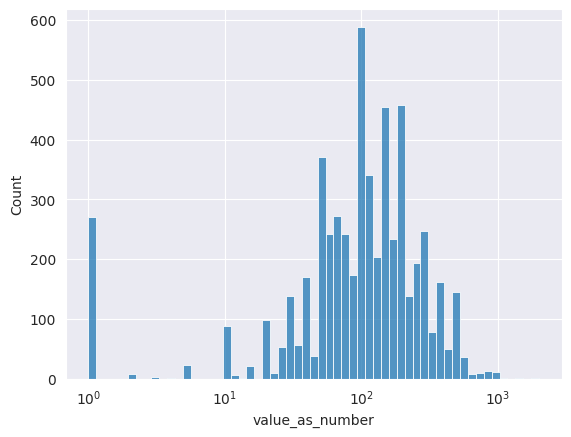

In [308]:
sns.set_style('darkgrid')
sns.histplot(UrineIncontinentie['value_as_number'], log_scale=True)

In [309]:
%%bigquery urine_check_duplicate --project esicmdatathon2024
select m.person_id, m.visit_occurrence_id, m.measurement_datetime, m.value_as_number
  FROM measurement m
inner join concept c
  on m.measurement_concept_id = c.concept_id
inner join visit_occurrence v
  on m.visit_occurrence_id = v.visit_occurrence_id
WHERE m.measurement_concept_id in (3014315, 3016267, 21491173, 3007123) -- Urine
  and m.provider_id is not null
  and m.measurement_datetime between v.visit_start_datetime and date_add (visit_start_datetime, Interval 6 hour)
  and m.value_as_number > 1 -- to avoid possible entries of 0 or 1 for "UrineIncontinentie"
--  and m.person_id = 7197 -- test only, random
limit 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [310]:
urine_check_duplicate

,person_id,visit_occurrence_id,measurement_datetime,value_as_number
0,14809,17152,2006-01-01 02:33:00+00:00,60.00000000000000000000000000000000000000
1,14809,17152,2006-01-01 02:33:00+00:00,60.00000000000000000000000000000000000000
2,13920,16129,2009-08-21 14:24:00+00:00,60.00000000000000000000000000000000000000
3,13920,16129,2009-08-21 14:24:00+00:00,60.00000000000000000000000000000000000000
4,14142,16386,2013-01-01 03:28:00+00:00,60.00000000000000000000000000000000000000
...,...,...,...,...
995,11658,13498,2006-01-11 13:33:00+00:00,60.00000000000000000000000000000000000000
996,12083,14010,2013-01-01 05:44:00+00:00,60.00000000000000000000000000000000000000
997,12083,14010,2013-01-01 05:44:00+00:00,60.00000000000000000000000000000000000000
998,12298,14266,2013-01-01 05:52:00+00:00,60.00000000000000000000000000000000000000


There are duplicates in urine, change the way of querying

In [311]:
%%bigquery urine_check_duplicate --project esicmdatathon2024
select distinct m.person_id, m.visit_occurrence_id, m.value_as_number , m.measurement_datetime
      , cast( floor((timestamp_diff(measurement_datetime, visit_start_datetime, minute )/60.0 ) /6.0) as int) as interval_block
        from measurement m
        inner join visit_occurrence v
          on m.visit_occurrence_id = v.visit_occurrence_id
          and date_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2
      where m.measurement_concept_id in (3014315, 3016267, 21491173, 3007123) -- Urine
        and m.provider_id is not null
        and m.measurement_datetime between v.visit_start_datetime and timestamp_add (visit_start_datetime, Interval 7*24 hour)
        and m.value_as_number > 0 -- to avoid possible entries of 0 for "UrineIncontinentie"
      and m.person_id = 19134 -- test only, random
  order by measurement_datetime


Query is running:   0%|          |

Downloading:   0%|          |

In [312]:
urine_check_duplicate

,person_id,visit_occurrence_id,value_as_number,measurement_datetime,interval_block
0,19134,22147,9000.00000000000000000000000000000000000000,2006-01-01 02:20:00+00:00,0
1,19134,22147,3000.00000000000000000000000000000000000000,2006-01-01 03:20:00+00:00,0
2,19134,22147,9500.00000000000000000000000000000000000000,2006-01-01 04:20:00+00:00,0
3,19134,22147,6600.00000000000000000000000000000000000000,2006-01-01 05:20:00+00:00,0
4,19134,22147,7500.00000000000000000000000000000000000000,2006-01-01 06:20:00+00:00,1
...,...,...,...,...,...
214,19134,22147,180.00000000000000000000000000000000000000,2006-01-07 17:20:00+00:00,26
215,19134,22147,150.00000000000000000000000000000000000000,2006-01-07 18:20:00+00:00,27
216,19134,22147,10.00000000000000000000000000000000000000,2006-01-07 20:20:00+00:00,27
217,19134,22147,120.00000000000000000000000000000000000000,2006-01-07 20:20:00+00:00,27


## Check rolling values

In [313]:
%%bigquery rolltest --project esicmdatathon2024
with hr_hours as (
  select distinct m.person_id, m.visit_occurrence_id,  DATETIME_TRUNC(measurement_datetime, HOUR) rounded_to_hour
  from visit_occurrence v
  inner join measurement m  on m.visit_occurrence_id = v.visit_occurrence_id
  where m.provider_id is not null
    and m.measurement_concept_id = 21490872 -- Heart rate.beat-to-beat by EKG
    and date_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2
    and m.measurement_datetime between v.visit_start_datetime
              and timestamp_add (visit_start_datetime, Interval 7*24 hour)
   and m.person_id = 12  -- random test
),
urine_hours as (
  select distinct m.person_id, m.visit_occurrence_id, m.value_as_number , m.measurement_datetime
    , DATETIME_TRUNC(measurement_datetime, HOUR) rounded_to_hour
  from measurement m
  inner join visit_occurrence v
  on m.visit_occurrence_id = v.visit_occurrence_id
  and date_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2
  where m.measurement_concept_id in (3014315, 3016267, 21491173, 3007123) -- Urine
    and m.provider_id is not null
    and m.measurement_datetime between v.visit_start_datetime and timestamp_add (visit_start_datetime, Interval 7*24 hour)
    and m.value_as_number > 1 -- to avoid possible entries of 0 for "UrineIncontinentie"
    and m.person_id = 12 -- test only, random
) ,
urine_fillnull as(
select h.*, ifnull(u.value_as_number,0) as urine_hour
from hr_hours h left outer join urine_hours u
on h.visit_occurrence_id = u.visit_occurrence_id
and h.rounded_to_hour = u.rounded_to_hour
)
select *
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 12 preceding and current row) as avg_12_roll_urine
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 6 preceding and current row) as avg_6_roll_urine
, array_agg(urine_hour)
over(partition by visit_occurrence_id order by rounded_to_hour rows between 6 preceding and current row) as roll_urine
from urine_fillnull


Query is running:   0%|          |

Downloading:   0%|          |

In [314]:
rolltest

,person_id,visit_occurrence_id,rounded_to_hour,urine_hour,avg_12_roll_urine,avg_6_roll_urine,roll_urine
0,12,12,2006-01-01 00:00:00+00:00,0E-38,0E-38,0E-38,[0E-38]
1,12,12,2006-01-01 01:00:00+00:00,110.00000000000000000000000000000000000000,55.00000000000000000000000000000000000000,55.00000000000000000000000000000000000000,"[0E-38, 110.0000000000000000000000000000000000..."
2,12,12,2006-01-01 02:00:00+00:00,150.00000000000000000000000000000000000000,86.66666666666666666666666666666666666667,86.66666666666666666666666666666666666667,"[0E-38, 110.0000000000000000000000000000000000..."
3,12,12,2006-01-01 03:00:00+00:00,180.00000000000000000000000000000000000000,110.00000000000000000000000000000000000000,110.00000000000000000000000000000000000000,"[0E-38, 110.0000000000000000000000000000000000..."
4,12,12,2006-01-01 04:00:00+00:00,130.00000000000000000000000000000000000000,114.00000000000000000000000000000000000000,114.00000000000000000000000000000000000000,"[0E-38, 110.0000000000000000000000000000000000..."
...,...,...,...,...,...,...,...
160,12,12,2006-01-07 19:00:00+00:00,80.00000000000000000000000000000000000000,338.07692307692307692307692307692307692308,272.85714285714285714285714285714285714286,"[440.00000000000000000000000000000000000000, 4..."
161,12,12,2006-01-07 20:00:00+00:00,30.00000000000000000000000000000000000000,323.46153846153846153846153846153846153846,214.28571428571428571428571428571428571429,"[410.00000000000000000000000000000000000000, 2..."
162,12,12,2006-01-07 21:00:00+00:00,320.00000000000000000000000000000000000000,330.76923076923076923076923076923076923077,201.42857142857142857142857142857142857143,"[260.00000000000000000000000000000000000000, 4..."
163,12,12,2006-01-07 22:00:00+00:00,0E-38,290.76923076923076923076923076923076923077,164.28571428571428571428571428571428571429,"[420.00000000000000000000000000000000000000, 0..."


# Urine rolling average per weight

In [315]:
%%bigquery urine_roll_avg --project esicmdatathon2024
with bd_wght as (
SELECT m.visit_occurrence_id, m.value_as_number as body_weight
  FROM measurement m
  WHERE measurement_concept_id in (3026600, 3013762, 3023166, 3025315) -- Body Weight
    AND m.provider_id IS NULL
) ,
-- using the heart rate to determine if a person is at the bedside, gets all hours of stay of a person
-- use "distinct" to remove duplicate entries
hr_hours as (
  select distinct m.person_id, m.visit_occurrence_id,  DATETIME_TRUNC(measurement_datetime, HOUR) rounded_to_hour
  from visit_occurrence v
  inner join measurement m  on m.visit_occurrence_id = v.visit_occurrence_id
  where m.provider_id is not null
    and m.measurement_concept_id = 21490872 -- Heart rate.beat-to-beat by EKG
    and date_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2
    and m.measurement_datetime between v.visit_start_datetime
              and timestamp_add (visit_start_datetime, Interval 7*24 hour)
  -- and m.person_id = 12  -- random test
),
-- get all urine output charted. round the measurement time to the nearest hour
-- use "distinct" to remove duplicate entries
urine_hours as (
  select distinct m.person_id, m.visit_occurrence_id, m.value_as_number , m.measurement_datetime
    , DATETIME_TRUNC(measurement_datetime, HOUR) rounded_to_hour
  from measurement m
  inner join visit_occurrence v
  on m.visit_occurrence_id = v.visit_occurrence_id
  and date_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2
  where m.measurement_concept_id in (3014315, 3016267, 21491173, 3007123) -- Urine
    and m.provider_id is not null
    and m.measurement_datetime between v.visit_start_datetime and timestamp_add (visit_start_datetime, Interval 7*24 hour)
    and m.value_as_number > 1 -- to avoid possible entries of 0 for "UrineIncontinentie"
  --  and m.person_id = 12 -- test only, random
) ,
-- fill all rows where there is a heart rate but no urine output as zero urine for the hour
urine_fillnull as(
select h.*, ifnull(u.value_as_number,0) as urine_hour
from hr_hours h left outer join urine_hours u
on h.visit_occurrence_id = u.visit_occurrence_id
and h.rounded_to_hour = u.rounded_to_hour
),
-- calculate 6 hour and 12 hour rolling averages
roll_avg as (
select person_id, visit_occurrence_id, rounded_to_hour
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 12 preceding and current row) as avg_12_roll_urine
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 6 preceding and current row) as avg_6_roll_urine
from urine_fillnull
)
select a.person_id, a.visit_occurrence_id, w.body_weight
, avg(avg_12_roll_urine/w.body_weight) AS urine_output_per_kg_avg_roll12hr
, avg(avg_6_roll_urine/w.body_weight) AS urine_output_per_kg_avg_roll6hr
from roll_avg a inner join bd_wght w
on a.visit_occurrence_id = w.visit_occurrence_id
group by a.person_id, a.visit_occurrence_id, w.body_weight

Query is running:   0%|          |

Downloading:   0%|          |

# Check results

<Axes: xlabel='urine_output_per_kg_avg_roll12hr', ylabel='Count'>

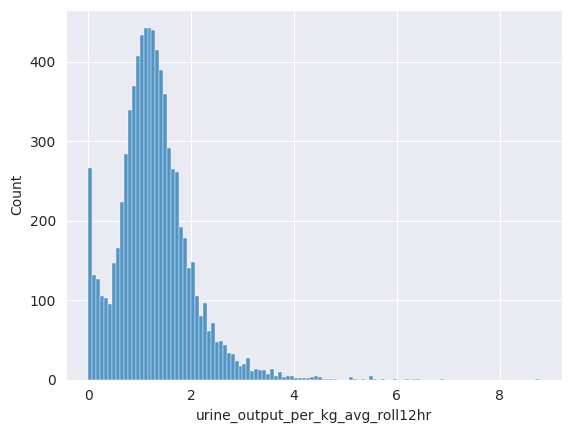

In [316]:
sns.histplot(urine_roll_avg['urine_output_per_kg_avg_roll12hr'])

<Axes: xlabel='urine_output_per_kg_avg_roll6hr', ylabel='Count'>

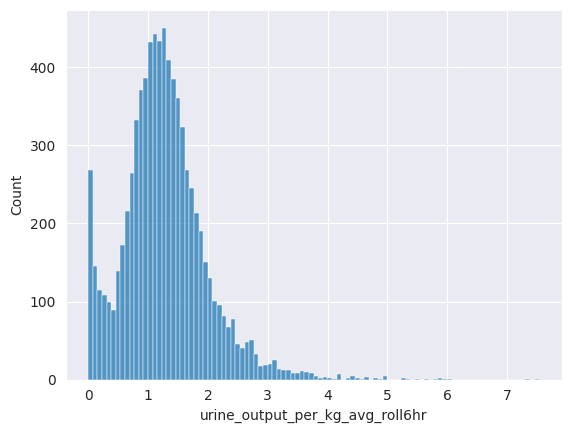

In [317]:
sns.histplot(urine_roll_avg['urine_output_per_kg_avg_roll6hr'])

In [318]:
urine_roll_avg.query('visit_occurrence_id == 12')

<ipython-input-318-fea5c5c2d32e>:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  urine_roll_avg.query('visit_occurrence_id == 12')


,person_id,visit_occurrence_id,body_weight,urine_output_per_kg_avg_roll12hr,urine_output_per_kg_avg_roll6hr
7619,12,12,95.00000000000000000000000000000000000000,1.58032740429869616472487285884415071018,1.60468443836864889496468443836864889496


sometimes i don't find any urine values although the patient is there (has heart rate charted)

In [324]:
urine_roll_avg.query('urine_output_per_kg_avg_roll12hr == 0')

,person_id,visit_occurrence_id,body_weight,urine_output_per_kg_avg_roll12hr,urine_output_per_kg_avg_roll6hr
669,9566,11079,85.00000000000000000000000000000000000000,0E-38,0E-38
1229,9217,10684,85.00000000000000000000000000000000000000,0E-38,0E-38
1592,4473,5152,85.00000000000000000000000000000000000000,0E-38,0E-38
1646,15378,17815,85.00000000000000000000000000000000000000,0E-38,0E-38
1926,18030,20889,85.00000000000000000000000000000000000000,0E-38,0E-38
2217,8301,9636,85.00000000000000000000000000000000000000,0E-38,0E-38
2400,360,415,65.00000000000000000000000000000000000000,0E-38,0E-38
2746,16597,19245,65.00000000000000000000000000000000000000,0E-38,0E-38
2967,11323,13125,65.00000000000000000000000000000000000000,0E-38,0E-38
3215,360,416,65.00000000000000000000000000000000000000,0E-38,0E-38


In [336]:
%%bigquery checkzero --project esicmdatathon2024
select distinct concept_name ,measurement_source_value, measurement_datetime, value_as_number
  from measurement m
  inner join concept c
  on m.measurement_concept_id = c.concept_id
  where m.provider_id is not null
    and m.person_id = 15989 -- 19420 -- test only, random
    and m.measurement_date = '2015-04-25'
  limit 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [337]:
checkzero

,concept_name,measurement_source_value,measurement_datetime,value_as_number
0,Dialysate temperature,MFT_Temperatuur (ingesteld),2015-04-25 01:05:00+00:00,39.00000000000000000000000000000000000000
1,Heart rate.beat-to-beat by EKG,Hartfrequentie,2015-04-25 13:05:00+00:00,99.00000000000000000000000000000000000000
2,Heart rate.beat-to-beat by EKG,Hartfrequentie,2015-04-25 00:05:00+00:00,100.00000000000000000000000000000000000000
3,Heart rate.beat-to-beat by EKG,Hartfrequentie,2015-04-25 06:05:00+00:00,102.00000000000000000000000000000000000000
4,Heart rate.beat-to-beat by EKG,Hartfrequentie,2015-04-25 14:05:00+00:00,107.00000000000000000000000000000000000000
...,...,...,...,...
322,Calcium.ionized [Moles/volume] adjusted to pH ...,Ca-ion (7.4) (bloed),2015-04-25 02:25:00+00:00,0.94000000000000000000000000000000000000
323,Hemoglobin [Moles/volume] in Blood,Hb(v.Bgs) (bloed),2015-04-25 09:38:00+00:00,6.00000000000000000000000000000000000000
324,Duration of hemodialysis session,MFT_Behandelingsduur,2015-04-25 01:05:00+00:00,20.60000000000000000000000000000000000000
325,Duration of hemodialysis session,MFT_Behandelingsduur,2015-04-25 05:05:00+00:00,24.33000000000000000000000000000000000000
